# Problema 1 - Análisis de Desinformación en Redes Sociales en las Elecciones Presidenciales

## *Autores*: 
- _Leonardo Ponce 202030531-5 (leonardo.ponde@usm.cl)_
- _Álvaro Pozo 202030535-8 (alvaro.pozo@usm.cl)_


## Contexto

En el marco de las elecciones presidenciales, las redes sociales han adquirido un rol
central como espacio de difusión de información, debate y propaganda política. Sin
embargo, también se han convertido en terreno fértil para la circulación de noticias
falsas (fake news), campañas de desinformación coordinada y el uso de cuentas
automatizadas (bots) que distorsionan la conversación pública.
Este problema busca que analicen cómo se propaga este tipo de información, qué
actores y comunidades la potencian, y cómo es posible identificar patrones ocultos
mediante el uso de redes, análisis temporal y procesamiento de texto.

## Objetivos

En esta primera parte se trabajará con datos de redes sociales asociados a las elecciones presidenciales. El foco está en estudiar cómo se propagan las noticias falsas en comparación con publicaciones legítimas.

Tareas principales:
1. Recolectar y organizar publicaciones relevantes sobre las elecciones (ej., con
palabras clave o enlaces compartidos).
2. Reconstruir cascadas de difusión (retuits, compartidos, menciones) como
grafos de propagación.
3. Calcular métricas de red (grado, betweenness, closeness, etc.) para identificar
actores que amplifican rumores.
4. Visualizar la dinámica temporal y geográfica de la propagación.
5. Distinguir posibles cuentas automatizadas a partir de sus patrones de actividad.


# Desarrollo del problema

## Parte 1

### Recolección de información

*Aqui debo explicar como se recolectó la información, desde que lugar y como*

### Lectura de dataset

In [19]:
import pandas as pd
import numpy as np

# Leer datas de archivos CSV
data1 = pd.read_csv('../data/Tweets_Elecciones2025_Chile.csv')

In [10]:
# verificar si hay filas duplicadas
print(data1.duplicated().sum())

0


In [22]:
print("Filas:", data1.shape)
print("Columnas:")
print(data1.columns.tolist())

# Mostrar primera fila del df
print(data1.iloc[0])

Filas: (6572, 24)
Columnas:
['Query_Str', 'Post_URL', 'Author_Name', 'Author_Web_Page_URL', 'Author_Handle', 'Verified_Status', 'UTC_Time', 'Ads', 'Tweet_Content', 'Post_ID', 'Tweet_URL', 'Reply_Count', 'Repost_Count', 'Like_Count', 'View_Count', 'Bookmark_Count', 'Tweet_Image_URL', 'Replying_to', 'Reply_to_Whom', 'Reply_to_Whom_URL', 'Reply_to_Whom_Username', 'Reply_to_Whom_Handle', 'Language', 'Type']
Query_Str                 elecciones presidenciales chile matthei desinf...
Post_URL                  https://x.com/search?q=elecciones presidencial...
Author_Name                                        Make Chile 5K Again 🖐️🇨🇱
Author_Web_Page_URL                              https://x.com/Kasterizador
Author_Handle                                                  Kasterizador
Verified_Status                                                       False
UTC_Time                                          2025-01-06 17:03:24+00:00
Ads                                                          

### Reconstrucción de cascadas de difusión

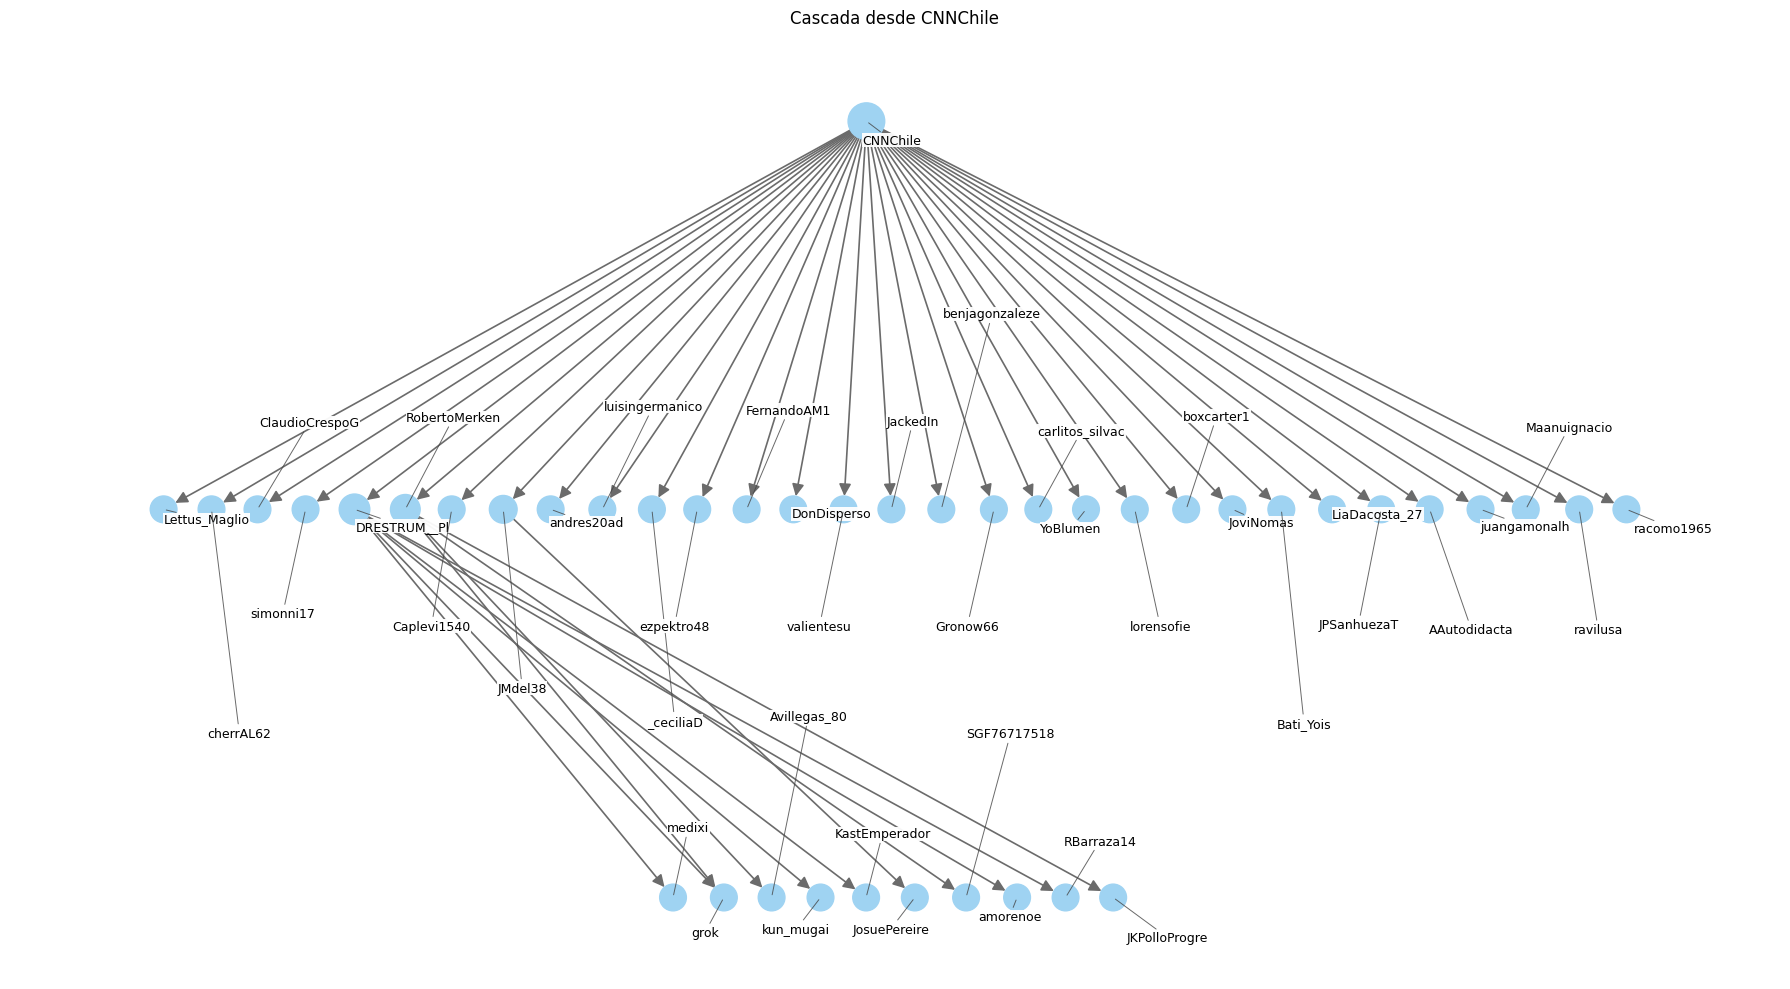

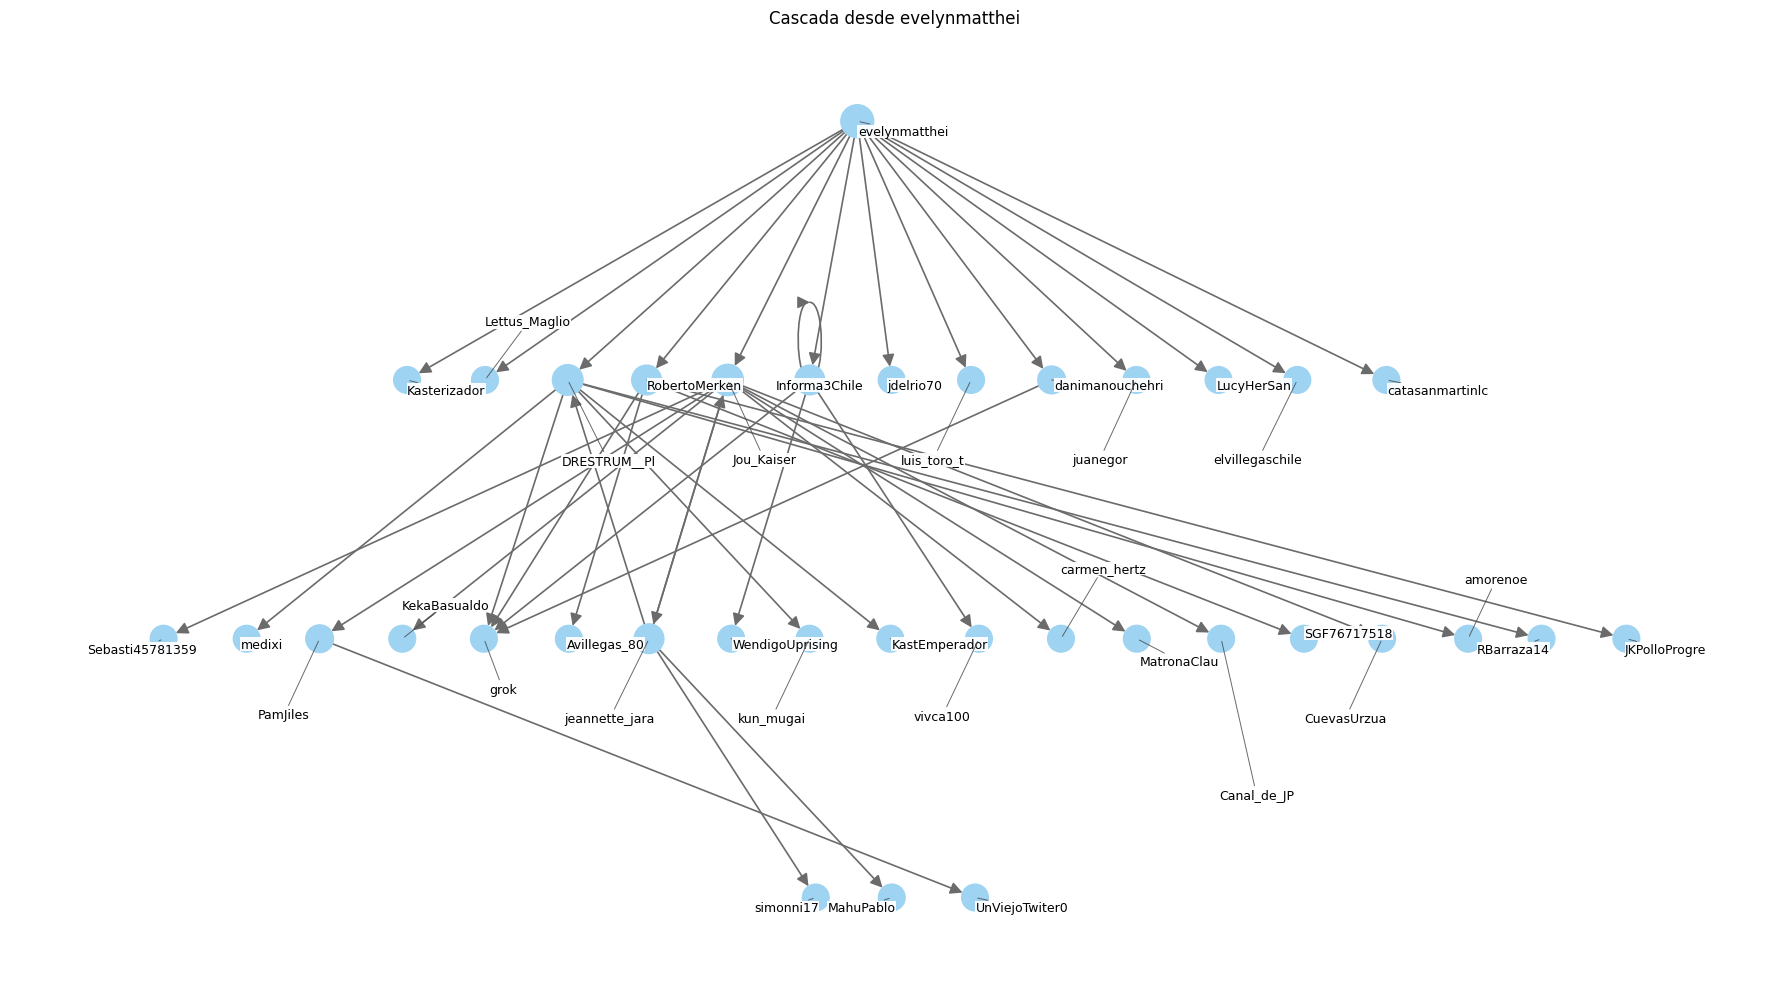

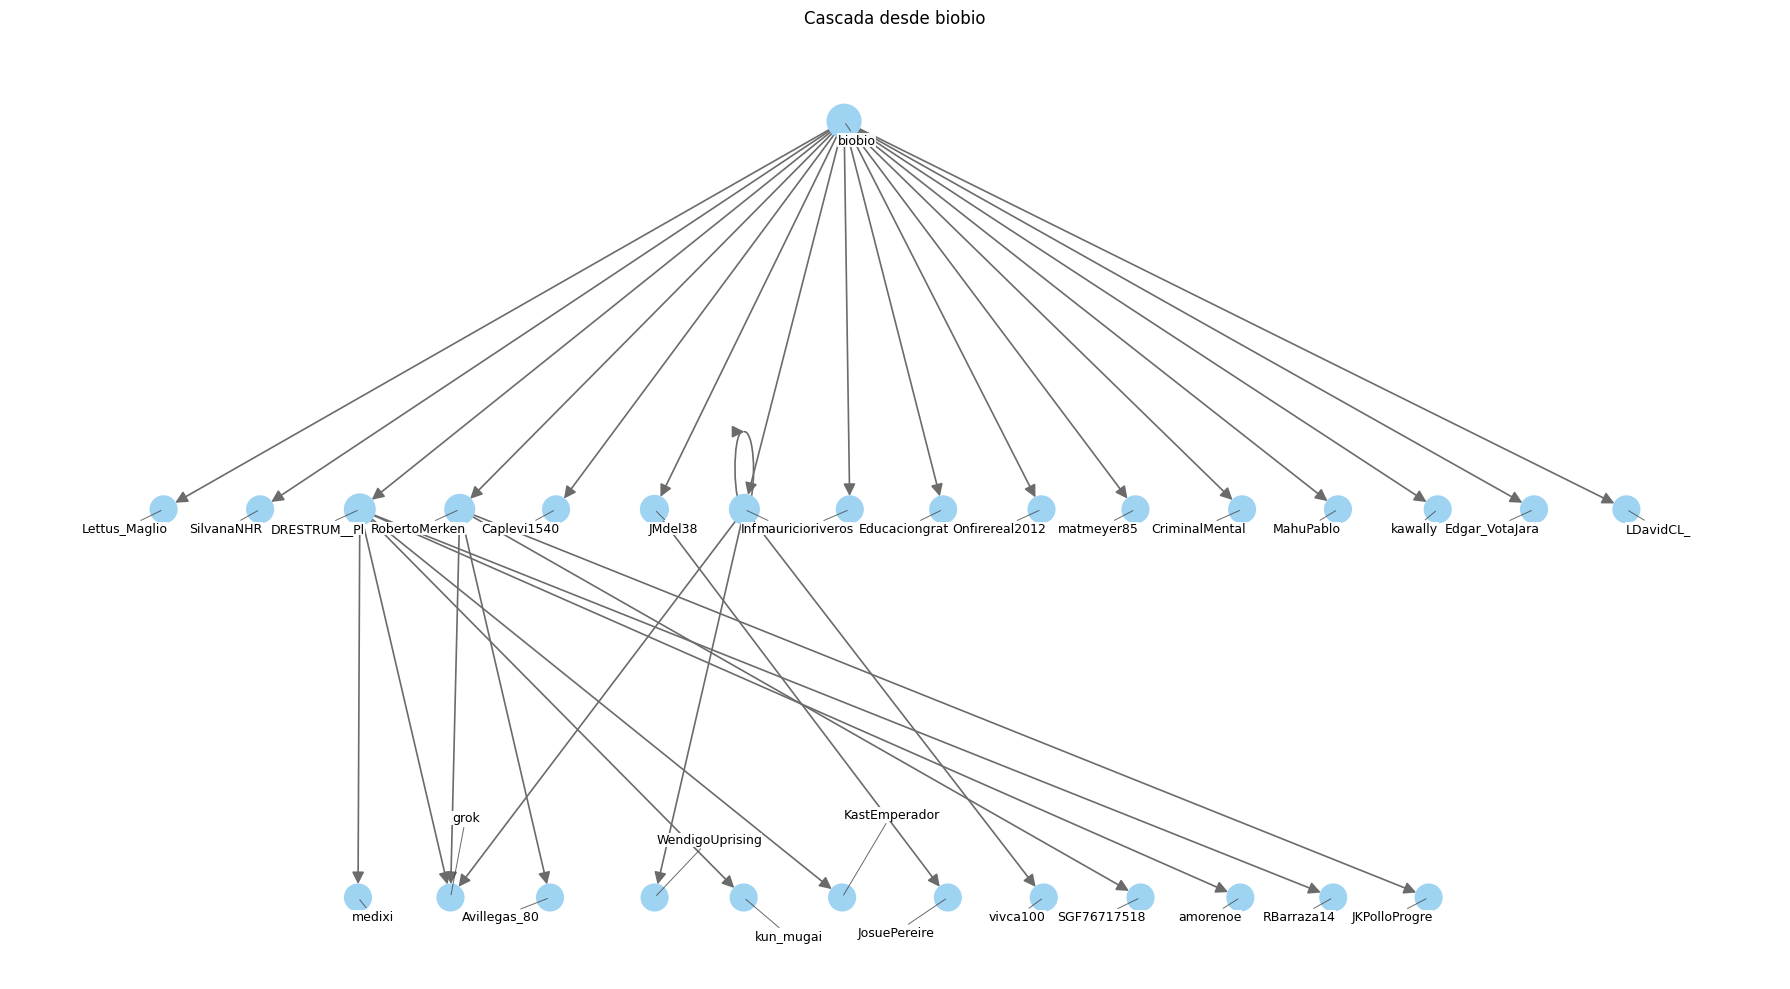

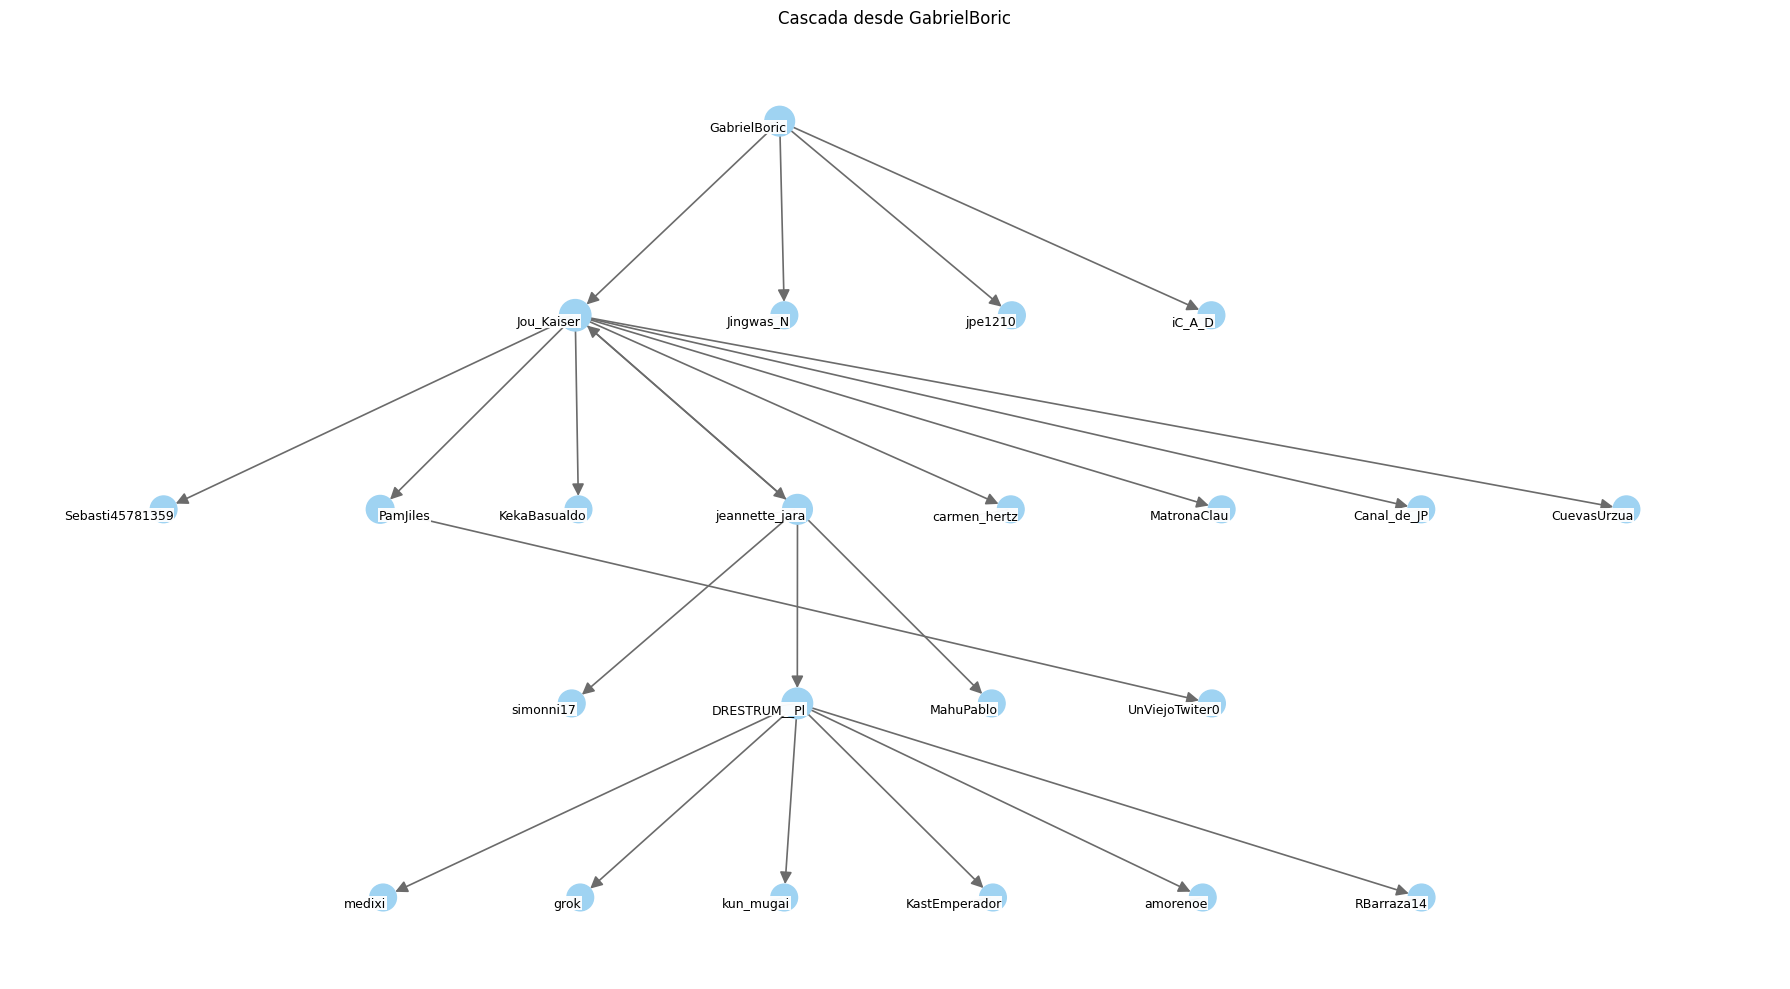

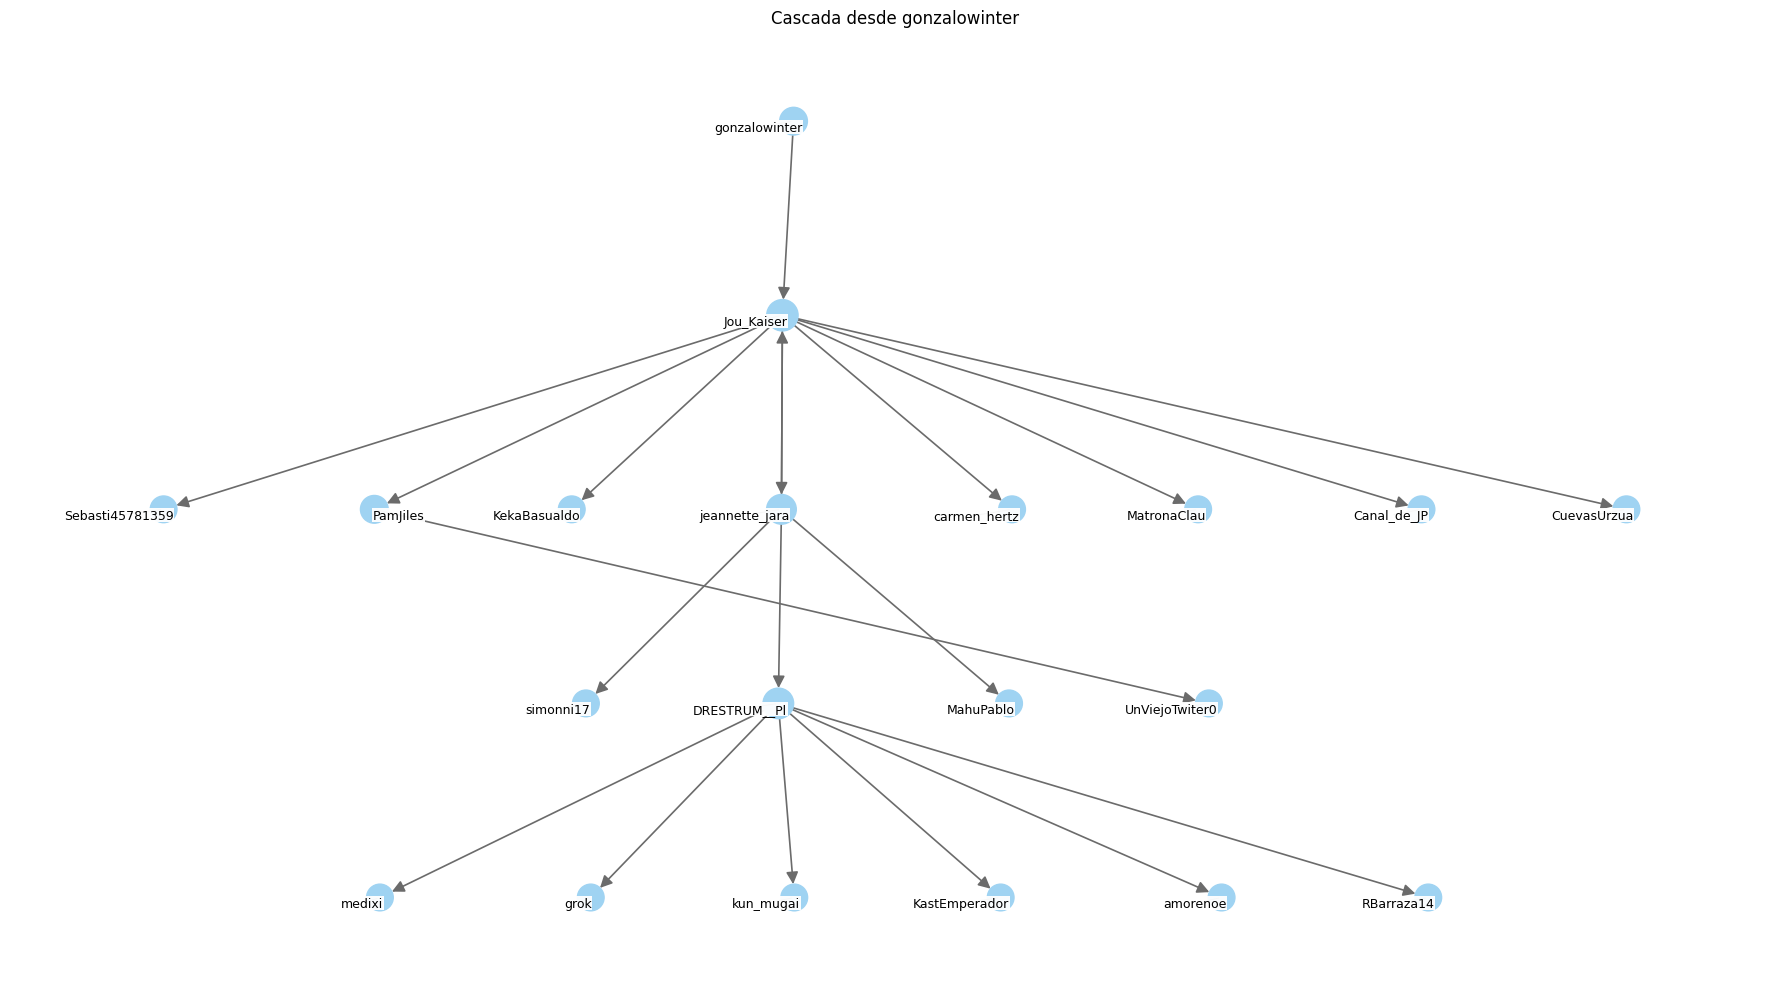

In [41]:
# =========================
#  Cascadas de replies con labels claros (debajo del nodo)
#  - No guarda imágenes (solo muestra)
#  - Texto con línea guía desde cada nodo
# =========================

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math, random

# ------------ 1) Grafo: origen -> responde ------------
G = nx.DiGraph()
for _, r in data1.iterrows():
    src = r.get('Reply_to_Whom_Handle')
    dst = r.get('Author_Handle')
    if pd.notna(src) and pd.notna(dst):
        src = str(src).strip()
        dst = str(dst).strip()
        if src and dst and src.lower() != 'nan' and dst.lower() != 'nan':
            G.add_edge(src, dst)

# Tiempos por autor (para fallback layout)
author_first_ts = (
    data1.dropna(subset=['Author_Handle','UTC_Time'])
         .assign(UTC_Time=lambda d: pd.to_datetime(d['UTC_Time'], utc=True, errors='coerce'))
         .sort_values('UTC_Time')
         .groupby('Author_Handle')['UTC_Time'].first()
         .to_dict()
)
nx.set_node_attributes(G, author_first_ts, name='time')

# ------------ 2) Raíces ordenadas por tamaño de cascada ------------
def cascade_size(root):
    return 1 + len(nx.descendants(G, root))

roots = [n for n in G.nodes if G.in_degree(n) == 0]
roots = sorted(roots, key=cascade_size, reverse=True)

# ------------ 3) Fallback layout jerárquico ------------
def hierarchical_pos(Gsub, root, level_gap=2.0, x_gap=1.6, jitter=0.10):
    levels = nx.shortest_path_length(Gsub, root)
    buckets = {}
    for n, d in levels.items():
        buckets.setdefault(d, []).append(n)

    def t_key(n):
        t = Gsub.nodes[n].get('time')
        if t is None or pd.isna(t):  # sin tiempo -> al final
            return pd.Timestamp.max.tz_localize('UTC')
        return t

    pos = {}
    for lvl, nodes in sorted(buckets.items()):
        ns = sorted(nodes, key=t_key)
        width = max(1, len(ns)-1)
        xs = [i * x_gap - width * x_gap/2 for i in range(len(ns))]
        for x, n in zip(xs, ns):
            pos[n] = (x + random.uniform(-jitter, jitter), -lvl * level_gap)
    return pos, levels

# ------------ 4) Helpers ------------
def shorten(label, maxlen=22):
    return label if len(label) <= maxlen else (label[:maxlen-1] + "…")

# ------------ 5) Dibujo ------------
def draw_cascade(G, root, min_nodes=8):
    nodes = nx.descendants(G, root) | {root}
    if len(nodes) < min_nodes:
        return

    S = G.subgraph(nodes).copy()

    # Posiciones: intenta Graphviz; si no, fallback
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(S, prog="dot")
        levels = nx.shortest_path_length(S, root)
    except Exception:
        pos, levels = hierarchical_pos(S, root)

    # Tamaño en función del out-degree (influencia local)
    outdeg = dict(S.out_degree())
    sizes = [300 + 70 * math.sqrt(outdeg.get(n,0)+1) for n in S.nodes]

    fig = plt.figure(figsize=(18, 10))
    ax = plt.gca()

    # Nodos y aristas
    nx.draw(
        S, pos,
        with_labels=False, node_size=sizes,
        node_color="#9fd3f2", edge_color="#6b6b6b",
        arrows=True, arrowstyle="-|>", arrowsize=18, width=1.2, ax=ax
    )

    # Labels: SIEMPRE debajo del nodo, centrados, con línea guía
    # dy controla qué tan abajo queda el texto (en coordenadas de datos)
    dy = 0.35
    texts = []
    for n, (x, y) in pos.items():
        label = shorten(n, 24)
        # Línea guía + caja blanca para el texto
        t = ax.annotate(
            label,
            xy=(x, y), xycoords='data',
            xytext=(x, y - dy), textcoords='data',
            ha='center', va='top',
            fontsize=9,
            bbox=dict(facecolor='white', alpha=0.95, pad=0.25, edgecolor='none'),
            arrowprops=dict(arrowstyle='-', lw=0.7, color='#444', alpha=0.8),
            zorder=10
        )
        texts.append(t)

    # Separación suave de textos (opcional)
    try:
        from adjustText import adjust_text
        adjust_text(
            texts,
            only_move={'points':'y', 'text':'y'},   # mueve textos solo verticalmente
            expand_points=(1.2, 1.2),
            expand_text=(1.05, 1.05),
            force_text=(0.1, 0.3),
            force_points=(0.2, 0.4),
            lim=150,
            ax=ax
        )
    except Exception:
        pass

    ax.set_title(f"Cascada desde {root}", pad=12)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# ------------ 6) Ejecutar (muestra, no guarda) ------------
NUM_CASCADAS = 5   # cuántas raíces graficar
for root in roots[:NUM_CASCADAS]:
    draw_cascade(G, root, min_nodes=8)


### Calculo de métricas

In [46]:
# ===========================================
#   MÉTRICAS SNA SOBRE TODO EL DATASET
#   (versión robusta: elimina self-loops)
# ===========================================

import pandas as pd
import networkx as nx
import numpy as np

# ---------------- 1) Construir G con TODO ----------------
G = nx.DiGraph()
for _, r in data1.iterrows():
    src = r.get('Reply_to_Whom_Handle')
    dst = r.get('Author_Handle')
    if pd.notna(src) and pd.notna(dst):
        src = str(src).strip()
        dst = str(dst).strip()
        if src and dst and src.lower() != 'nan' and dst.lower() != 'nan':
            G.add_edge(src, dst)

print(f"Nodos totales: {G.number_of_nodes():,} | Aristas totales: {G.number_of_edges():,}")

# 🔧 Eliminar self-loops (respuestas a sí mismo)
self_loops = list(nx.selfloop_edges(G))
if self_loops:
    print(f"Eliminando {len(self_loops)} self-loops...")
    G.remove_edges_from(self_loops)

# ---------------- 2) Métricas base (dirigido) ----------------
deg_total  = dict(G.degree())
deg_in     = dict(G.in_degree())
deg_out    = dict(G.out_degree())

bet = nx.betweenness_centrality(G, normalized=True)
harmonic = nx.harmonic_centrality(G)
pr = nx.pagerank(G, alpha=0.85)

try:
    eig = nx.eigenvector_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
    eig = {n: 0.0 for n in G.nodes()}

# ---------------- 3) Métricas adicionales (no dirigido) ----------------
G_u = G.to_undirected(reciprocal=False)
core = nx.core_number(G_u)
clust = nx.clustering(G_u)

# ---------------- 4) DataFrame con TODAS las métricas ----------------
metrics_df = pd.DataFrame({
    'degree': pd.Series(deg_total),
    'in_degree': pd.Series(deg_in),
    'out_degree': pd.Series(deg_out),
    'betweenness': pd.Series(bet),
    'harmonic_closeness': pd.Series(harmonic),
    'pagerank': pd.Series(pr),
    'eigenvector': pd.Series(eig),
    'k_core': pd.Series(core),
    'clustering': pd.Series(clust)
}).fillna(0)

print("Guardando todas las métricas en 'metricas.csv'...")
metrics_df.to_csv('metricas.csv', encoding='utf-8')
print("¡Archivo 'metricas.csv' guardado exitosamente!")

# ---------------- 5) Score de “amplificador de rumores” ----------------
def minmax(s):
    s = s.astype(float)
    return (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else pd.Series(0, index=s.index)

mm_out = minmax(metrics_df['out_degree'])
mm_bet = minmax(metrics_df['betweenness'])
mm_har = minmax(metrics_df['harmonic_closeness'])
mm_pr  = minmax(metrics_df['pagerank'])

metrics_df['amplifier_score'] = (
    0.35*mm_out + 0.35*mm_bet + 0.15*mm_har + 0.15*mm_pr
)

# ---------------- 6) Resultados: TOP N ----------------
TOP_N = 20
top_amplifiers = metrics_df.sort_values('amplifier_score', ascending=False).head(TOP_N)
top_bridges    = metrics_df.sort_values('betweenness', ascending=False).head(TOP_N)
top_speakers   = metrics_df.sort_values('out_degree', ascending=False).head(TOP_N)
top_hubs       = metrics_df.sort_values('pagerank', ascending=False).head(TOP_N)

display(top_amplifiers.style.set_caption("Top amplificadores (score combinado)"))
display(top_bridges.style.set_caption("Top 'puentes' (betweenness)"))
display(top_speakers.style.set_caption("Top emisores (out-degree)"))
display(top_hubs.style.set_caption("Top hubs estructurales (PageRank)"))


Nodos totales: 631 | Aristas totales: 504
Eliminando 40 self-loops...
Guardando todas las métricas en 'metricas.csv'...
¡Archivo 'metricas.csv' guardado exitosamente!


,degree,in_degree,out_degree,betweenness,harmonic_closeness,pagerank,eigenvector,k_core,clustering,amplifier_score
Jou_Kaiser,12,4,8,0.000139,4.000000,0.002704,0.229411,2,0,0.491370
DRESTRUM__Pl,12,6,6,0.000131,7.166667,0.002662,0.229412,3,0,0.472430
CNNChile,31,0,31,0.000000,0.000000,0.001129,0.000000,3,0,0.350000
grok,12,12,0,0.000000,20.833333,0.011747,0.229467,3,0,0.300000
RobertoMerken,11,7,4,0.000065,7.000000,0.002414,0.000002,3,0,0.276512
jeannette_jara,5,1,4,0.000073,2.500000,0.001416,0.229411,2,0,0.251763
Informa3Chile,8,5,3,0.000034,5.000000,0.003503,0.000001,3,0,0.189841
biobio,16,0,16,0.000000,0.000000,0.001129,0.000000,3,0,0.180645
SilvanaNHR,11,11,0,0.000000,11.000000,0.006229,0.000003,3,0,0.151238
evelynmatthei,13,0,13,0.000000,0.000000,0.001129,0.000000,3,0,0.146774


,degree,in_degree,out_degree,betweenness,harmonic_closeness,pagerank,eigenvector,k_core,clustering,amplifier_score
Jou_Kaiser,12,4,8,0.000139,4.000000,0.002704,0.229411,2,0,0.491370
DRESTRUM__Pl,12,6,6,0.000131,7.166667,0.002662,0.229412,3,0,0.472430
jeannette_jara,5,1,4,0.000073,2.500000,0.001416,0.229411,2,0,0.251763
RobertoMerken,11,7,4,0.000065,7.000000,0.002414,0.000002,3,0,0.276512
Informa3Chile,8,5,3,0.000034,5.000000,0.003503,0.000001,3,0,0.189841
MatiAromi,7,2,5,0.000025,2.000000,0.001929,0.000001,1,0,0.145788
santisiri,4,2,2,0.000023,2.500000,0.003864,0.000003,1,0,0.136490
BotCheckerCL,6,4,2,0.000019,4.000000,0.003849,0.000001,2,0,0.137528
CarlosMaslaton,4,3,1,0.000015,4.333333,0.004692,0.000026,1,0,0.130999
PamJiles,2,1,1,0.000013,3.000000,0.001416,0.229411,1,0,0.068765


,degree,in_degree,out_degree,betweenness,harmonic_closeness,pagerank,eigenvector,k_core,clustering,amplifier_score
CNNChile,31,0,31,0.000000,0.000000,0.001129,0.000000,3,0,0.350000
biobio,16,0,16,0.000000,0.000000,0.001129,0.000000,3,0,0.180645
evelynmatthei,13,0,13,0.000000,0.000000,0.001129,0.000000,3,0,0.146774
petrogustavo,12,0,12,0.000000,0.000000,0.001129,0.000000,1,0,0.135484
latercera,9,0,9,0.000000,0.000000,0.001129,0.000000,3,0,0.101613
adnradiochile,9,0,9,0.000000,0.000000,0.001129,0.000000,3,0,0.101613
T13,9,0,9,0.000000,0.000000,0.001129,0.000000,2,0,0.101613
JMilei,8,0,8,0.000000,0.000000,0.001129,0.000000,1,0,0.090323
Jou_Kaiser,12,4,8,0.000139,4.000000,0.002704,0.229411,2,0,0.491370
thecliniccl,6,0,6,0.000000,0.000000,0.001129,0.000000,2,0,0.067742


,degree,in_degree,out_degree,betweenness,harmonic_closeness,pagerank,eigenvector,k_core,clustering,amplifier_score
grok,12,12,0,0.000000,20.833333,0.011747,0.229467,3,0,0.300000
JackSpartanXX,6,6,0,0.000000,6.000000,0.006888,0.000002,1,0,0.124561
SilvanaNHR,11,11,0,0.000000,11.000000,0.006229,0.000003,3,0,0.151238
andresmego,1,1,0,0.000000,3.416667,0.005114,0.000144,1,0,0.080894
CarlosMaslaton,4,3,1,0.000015,4.333333,0.004692,0.000026,1,0,0.130999
simonni17,6,6,0,0.000000,7.500000,0.004447,0.229412,2,0,0.100878
DalasReview,3,3,0,0.000000,3.000000,0.004009,0.000001,1,0,0.062280
santisiri,4,2,2,0.000023,2.500000,0.003864,0.000003,1,0,0.136490
tatilucci,2,2,0,0.000000,2.500000,0.003864,0.000003,1,0,0.056636
BotCheckerCL,6,4,2,0.000019,4.000000,0.003849,0.000001,2,0,0.137528


### Visualización dinámica

#### Visualización temporal

C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\756890215.py:97: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  plt.tight_layout()
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\756890215.py:97: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\756890215.py:97: UserWarning: Glyph 127939 (\N{RUNNER}) missing from current font.
  plt.tight_layout()
c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\site-packages

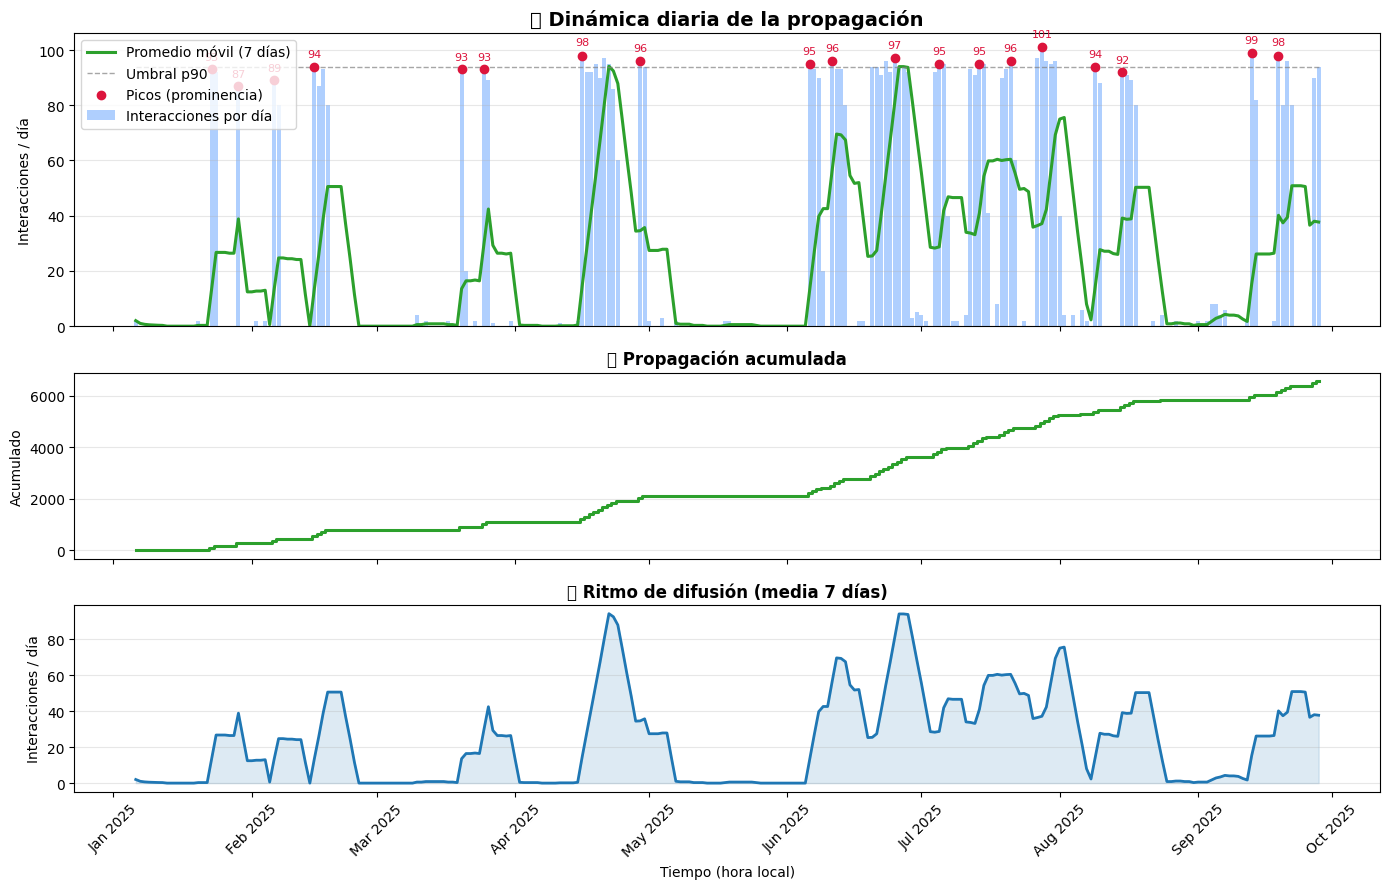

C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\756890215.py:118: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


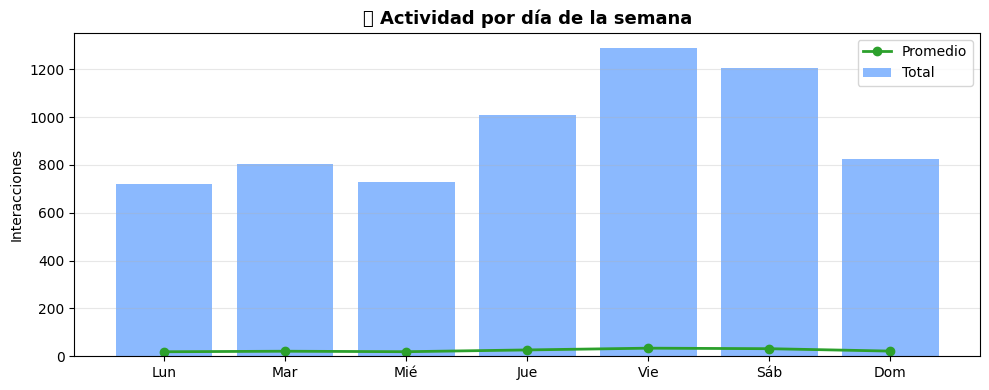

In [67]:
# ==========================================
#  Timeline DIARIO: claro y sin ambigüedad
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------- Config ----------
ROLL_DIAS = 7                 # suavizado
PCT_UMBRAL = 0.90             # línea horizontal de referencia (percentil)
DIST_MIN_PICOS = 3            # distancia mínima entre picos (en días)
USE_LOCAL_TZ = True
LOCAL_TZ = 'America/Santiago'

# ---------- Preparación ----------
df = data1.copy()
df['UTC_Time'] = pd.to_datetime(df['UTC_Time'], utc=True, errors='coerce')
df = df.dropna(subset=['UTC_Time']).sort_values('UTC_Time')

# Serie diaria
ts_day = (df.set_index('UTC_Time')
            .resample('D')
            .size()
            .rename('interacciones'))

if USE_LOCAL_TZ:
    ts_day.index = ts_day.index.tz_convert(LOCAL_TZ)

# Suavizado y acumulado
roll = ts_day.rolling(ROLL_DIAS, min_periods=1).mean()
acum = ts_day.cumsum()

# ---------- Detección de picos (método por prominencia) ----------
# Intentamos con scipy; si no está, hacemos un fallback simple.
peaks_idx = []
try:
    from scipy.signal import find_peaks
    # Umbral de prominencia relativo a la distribución
    prom = np.quantile(ts_day.values, 0.85) * 0.4  # ajuste conservador
    peaks_idx, _ = find_peaks(ts_day.values,
                              distance=DIST_MIN_PICOS,
                              prominence=prom)
except Exception:
    # Fallback: picos por percentil + "máximos locales" básicos
    s = ts_day
    is_peak = (s >= s.quantile(PCT_UMBRAL)) & (s.shift(1) <= s) & (s.shift(-1) <= s)
    peaks_idx = np.where(is_peak.values)[0]

peak_dates = ts_day.index[peaks_idx]
peak_vals  = ts_day.values[peaks_idx]

# Línea de referencia (percentil)
umbral = ts_day.quantile(PCT_UMBRAL)

# ---------- FIGURA: 3 paneles apilados, mismo eje X ----------
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(14, 9), sharex=True, gridspec_kw={'height_ratios':[2.2,1.4,1.4]}
)

# 1) Conteo diario + suavizado + picos
ax1.bar(ts_day.index, ts_day.values, width=0.9, color='#6ea8fe', alpha=0.55, label='Interacciones por día')
ax1.plot(roll.index, roll.values, color='#2ca02c', lw=2.2, label=f'Promedio móvil ({ROLL_DIAS} días)')
ax1.hlines(umbral, ts_day.index.min(), ts_day.index.max(), colors='gray', linestyles='--',
           linewidth=1, alpha=0.7, label=f'Umbral p{int(PCT_UMBRAL*100)}')

# Marcar picos
ax1.scatter(peak_dates, peak_vals, color='crimson', zorder=3, label='Picos (prominencia)')
for x, y in zip(peak_dates, peak_vals):
    ax1.text(x, y + max(0.03*y, 0.6), f"{int(y)}", ha='center', va='bottom', fontsize=8, color='crimson')

ax1.set_title("📅 Dinámica diaria de la propagación", fontsize=14, weight='bold')
ax1.set_ylabel("Interacciones / día")
ax1.grid(axis='y', alpha=0.3)
ax1.legend(loc='upper left')

# 2) Acumulado (solo línea escalonada)
ax2.step(acum.index, acum.values, where='mid', color='#2ca02c', lw=2.2)
ax2.set_title("📈 Propagación acumulada", fontsize=12, weight='bold')
ax2.set_ylabel("Acumulado")
ax2.grid(axis='y', alpha=0.3)

# 3) Ritmo diario (línea suave, sin eje secundario)
ritmo = ts_day.rolling(ROLL_DIAS, min_periods=1).mean()
ax3.plot(ritmo.index, ritmo.values, color='#1f77b4', lw=2)
ax3.fill_between(ritmo.index, ritmo.values, color='#1f77b4', alpha=0.15)
ax3.set_title(f"🏃 Ritmo de difusión (media {ROLL_DIAS} días)", fontsize=12, weight='bold')
ax3.set_ylabel("Interacciones / día")
ax3.grid(axis='y', alpha=0.3)

# Formato de fechas (común al eje X)
ax3.set_xlabel("Tiempo (hora local)")
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ==========================================================
#  Día de la semana (figura simple y clara)
# ==========================================================
dow_labels = ['Lun','Mar','Mié','Jue','Vie','Sáb','Dom']
dow_num = ts_day.index.dayofweek
df_dow = pd.DataFrame({'dow': dow_num, 'count': ts_day.values})

totales = df_dow.groupby('dow')['count'].sum().reindex(range(7), fill_value=0)
prom = df_dow.groupby('dow')['count'].mean().reindex(range(7), fill_value=0)

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(7), totales.values, color='#6ea8fe', alpha=0.8, label='Total')
ax.plot(range(7), prom.values, color='#2ca02c', marker='o', lw=2, label='Promedio')
ax.set_xticks(range(7)); ax.set_xticklabels(dow_labels)
ax.set_title("📊 Actividad por día de la semana", fontsize=13, weight='bold')
ax.set_ylabel("Interacciones")
ax.grid(axis='y', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()



#### Visualización geografica

In [56]:
# ==========================================
# INFERENCIA DE PAÍS A PARTIR DE IDIOMA Y DOMINIO
# ==========================================
import pandas as pd
import re

# Copiamos para no dañar el original
df_geo = data1.copy()

# --- 1) Basado en el campo 'Language' ---
lang_to_country = {
    'es': 'Chile/LatAm',  # español genérico
    'en': 'USA/UK',
    'pt': 'Brasil',
    'fr': 'Francia',
    'it': 'Italia',
    'de': 'Alemania',
    'ja': 'Japón',
    'zh': 'China',
    'ar': 'Medio Oriente',
    'tr': 'Turquía',
    'ru': 'Rusia'
}
df_geo['Country_Lang'] = df_geo['Language'].map(lang_to_country)

# --- 2) Basado en dominio de la URL (si existe) ---
def infer_country_from_url(url):
    if pd.isna(url): return None
    url = url.lower()
    # Dominio de nivel superior
    m = re.search(r'\.([a-z]{2})(?:/|$)', url)
    if not m:
        return None
    tld = m.group(1)
    tld_map = {
        'cl': 'Chile', 'ar': 'Argentina', 'mx': 'México', 'co': 'Colombia',
        'pe': 'Perú', 'br': 'Brasil', 'es': 'España', 'us': 'EEUU',
        'uk': 'Reino Unido', 'fr': 'Francia', 'de': 'Alemania',
        'it': 'Italia', 'jp': 'Japón', 'pt': 'Portugal'
    }
    return tld_map.get(tld, None)

df_geo['Country_URL'] = df_geo['Author_Web_Page_URL'].apply(infer_country_from_url)
df_geo['Country_Post'] = df_geo['Post_URL'].apply(infer_country_from_url)

# --- 3) Columna final (prioridad: URL > Language) ---
df_geo['Country_inferred'] = (
    df_geo['Country_URL']
    .combine_first(df_geo['Country_Post'])
    .combine_first(df_geo['Country_Lang'])
)

# --- Revisión rápida ---
print(df_geo['Country_inferred'].value_counts().head(10))


Country_inferred
Chile/LatAm    6484
USA/UK           19
Brasil           18
Francia           3
Turquía           1
Name: count, dtype: int64


              Country_world  num_posts
0                    Brazil         18
1                     Chile       6484
2                    France          3
3                    Turkey          1
4  United States of America         19


C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\3903122409.py:30: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


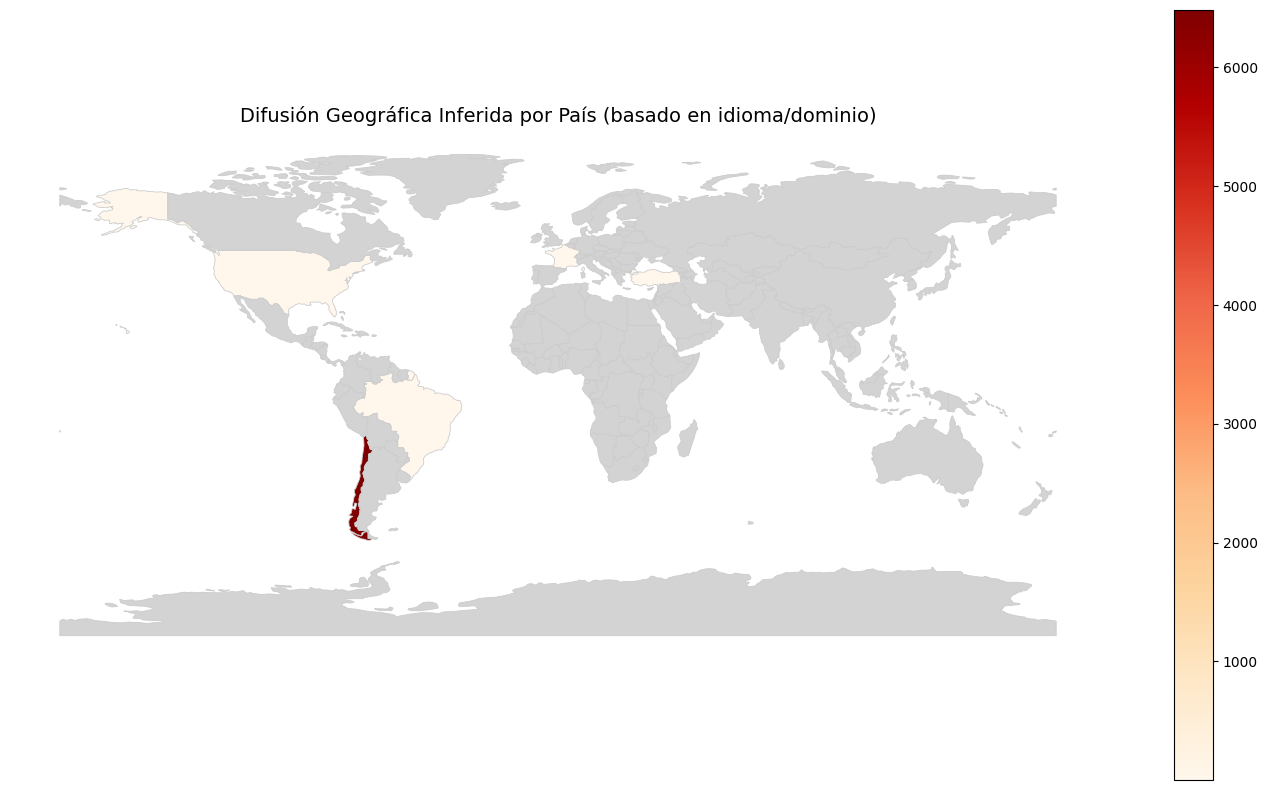

In [59]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# df_geo viene de tu paso anterior:
# df_geo['Country_inferred'] con valores como: Chile/LatAm, USA/UK, Brasil, Francia, Turquía

# 1) Normalizar a los nombres del shapefile (Natural Earth, columna 'name' en inglés)
name_map = {
    'Chile/LatAm': 'Chile',                 # si quieres representar LatAm con Chile
    'USA/UK': 'United States of America',   # usa USA (también podrías dividir a UK si quieres)
    'Brasil': 'Brazil',
    'Francia': 'France',
    'Turquía': 'Turkey',
    # agrega más equivalencias si aparecen
}
df_geo = df_geo.copy()
df_geo['Country_world'] = df_geo['Country_inferred'].map(name_map)

# 2) Agrupar (descarta nulos que no tengan mapeo)
geo_counts = (df_geo
              .dropna(subset=['Country_world'])
              .groupby('Country_world')
              .size()
              .reset_index(name='num_posts'))

print(geo_counts)

# 3) Cargar mapa base y unir
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_merged = world.merge(geo_counts, how='left',
                           left_on='name', right_on='Country_world')

# 4) Plot
fig, ax = plt.subplots(figsize=(14, 8))
world_merged.plot(
    column='num_posts',
    cmap='OrRd',
    linewidth=0.6,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    missing_kwds={'color': 'lightgrey', 'label': 'Sin datos'}
)
plt.title("Difusión Geográfica Inferida por País (basado en idioma/dominio)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()



### Distinguir cuentas automatizadas (mediante patrones)

✅ Archivo CSV cargado exitosamente.

--- Conteo de Tuits por Usuario ---
Author_Handle
Kasterizador       217
_istlady_          197
RobertoMerken      155
Informa3Chile      147
EncuestasChil10    131
                  ... 
kattym94             1
luiscostabonino      1
Johnenladeep         1
ElTanoOpina          1
Bajarlaalpasto       1
Name: count, Length: 1981, dtype: int64

📝 Conteo completo guardado en 'conteo_tweets_por_usuario.csv'


C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\289234840.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_users.values, y=top_users.index, palette='viridis', orient='h')



📈 Gráfico 'top_usuarios_por_tweets_con_numeros.png' generado exitosamente.


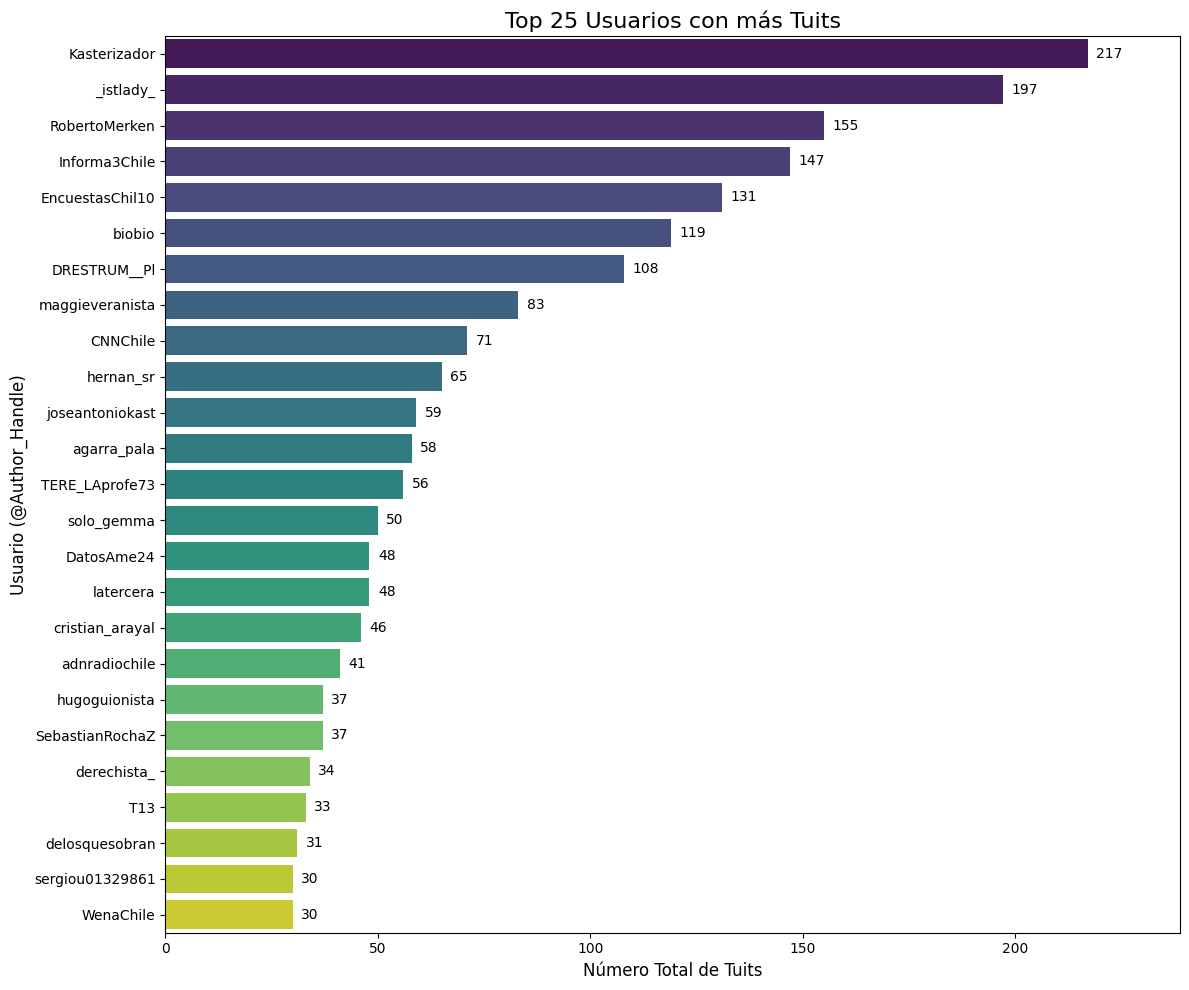

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # 1. Cargar el dataset
    df = pd.read_csv('../data/Tweets_Elecciones2025_Chile.csv')
    print("✅ Archivo CSV cargado exitosamente.")

    # 2. Calcular el número de tuits por usuario
    user_tweet_counts = df['Author_Handle'].value_counts()
    
    print("\n--- Conteo de Tuits por Usuario ---")
    print(user_tweet_counts)
    
    user_tweet_counts.to_csv('conteo_tweets_por_usuario.csv', header=['tweet_count'])
    print("\n📝 Conteo completo guardado en 'conteo_tweets_por_usuario.csv'")


    # --- 3. Generar un Gráfico Legible con Números por Barra ---
    
    top_n = 25
    top_users = user_tweet_counts.head(top_n)

    plt.figure(figsize=(12, 10))
    
    # El comando barplot ahora se asigna a 'ax' para poder manipular el gráfico
    ax = sns.barplot(x=top_users.values, y=top_users.index, palette='viridis', orient='h')
    
    # --- AÑADIDO: Bucle para agregar el número al final de cada barra ---
    for i in ax.patches:
        # La función ax.text() coloca texto en el gráfico
        # i.get_width() es el largo de la barra (el número de tuits)
        # i.get_y() es la posición 'y' de la barra
        ax.text(i.get_width() + 2,  # Posición x del texto (un poco a la derecha de la barra)
                i.get_y() + i.get_height() / 2, # Posición y del texto (centrado en la barra)
                f'{int(i.get_width())}', # El número a mostrar (como entero)
                ha='left', va='center', # Alineación del texto
                fontsize=10, color='black')
    
    # Ajustar el límite del eje X para dar espacio a los números
    ax.set_xlim(right=top_users.values.max() * 1.1)

    plt.title(f'Top {top_n} Usuarios con más Tuits', fontsize=16)
    plt.xlabel('Número Total de Tuits', fontsize=12)
    plt.ylabel('Usuario (@Author_Handle)', fontsize=12)
    
    plt.tight_layout()
    
    graph_filename = 'top_usuarios_por_tweets_con_numeros.png'
    plt.savefig(graph_filename)
    print(f"\n📈 Gráfico '{graph_filename}' generado exitosamente.")


except FileNotFoundError:
    print("⚠️ Error: El archivo 'Tweets_Elecciones2025_Chile.csv' no se encontró.")
    print("Por favor, asegúrate de que el archivo CSV está en el mismo directorio que el script.")
except KeyError as e:
    print(f"⚠️ Error de Clave: No se encontró la columna {e} en el archivo.")
    print("Por favor, verifica que los nombres de las columnas en tu CSV sean correctos.")
except Exception as e:
    print(f"Ha ocurrido un error inesperado: {e}")


Umbrales
- Bot Score 0-20: "Humano"
- Bot Score 21-50: "Sospechoso"
- Bot Score 51-100: "Bot_Probable"

Analizando patrones de comportamiento...
Total de tweets: 6572
Total de usuarios: 1981

ANÁLISIS AVANZADO DE DETECCIÓN DE BOTS

Usuarios analizados: 408

Distribución de clasificación:
Clasificacion
Humano          305
Sospechoso       73
Bot_Probable     30
Name: count, dtype: int64

Estadísticas del Bot Score:
count    408.000000
mean      15.686275
std       23.355381
min        0.000000
25%        0.000000
50%        0.000000
75%       40.000000
max      100.000000
Name: Bot_Score, dtype: float64

TOP 20 CUENTAS CON MAYOR PROBABILIDAD DE SER BOTS
  Author_Handle  Total_Tweets  Bot_Score  Indicadores_Bot  Tweets_Per_Hour  Ratio_Retweets  Solo_Retweets  Ratio_Duplicacion_Contenido  CV_Intervalos Clasificacion
      lobofacho             8      100.0                5             0.00               0          False                        0.000          1.279  Bot_Probable
Chileno17039890            11      100.0                5             0.00               0          False          

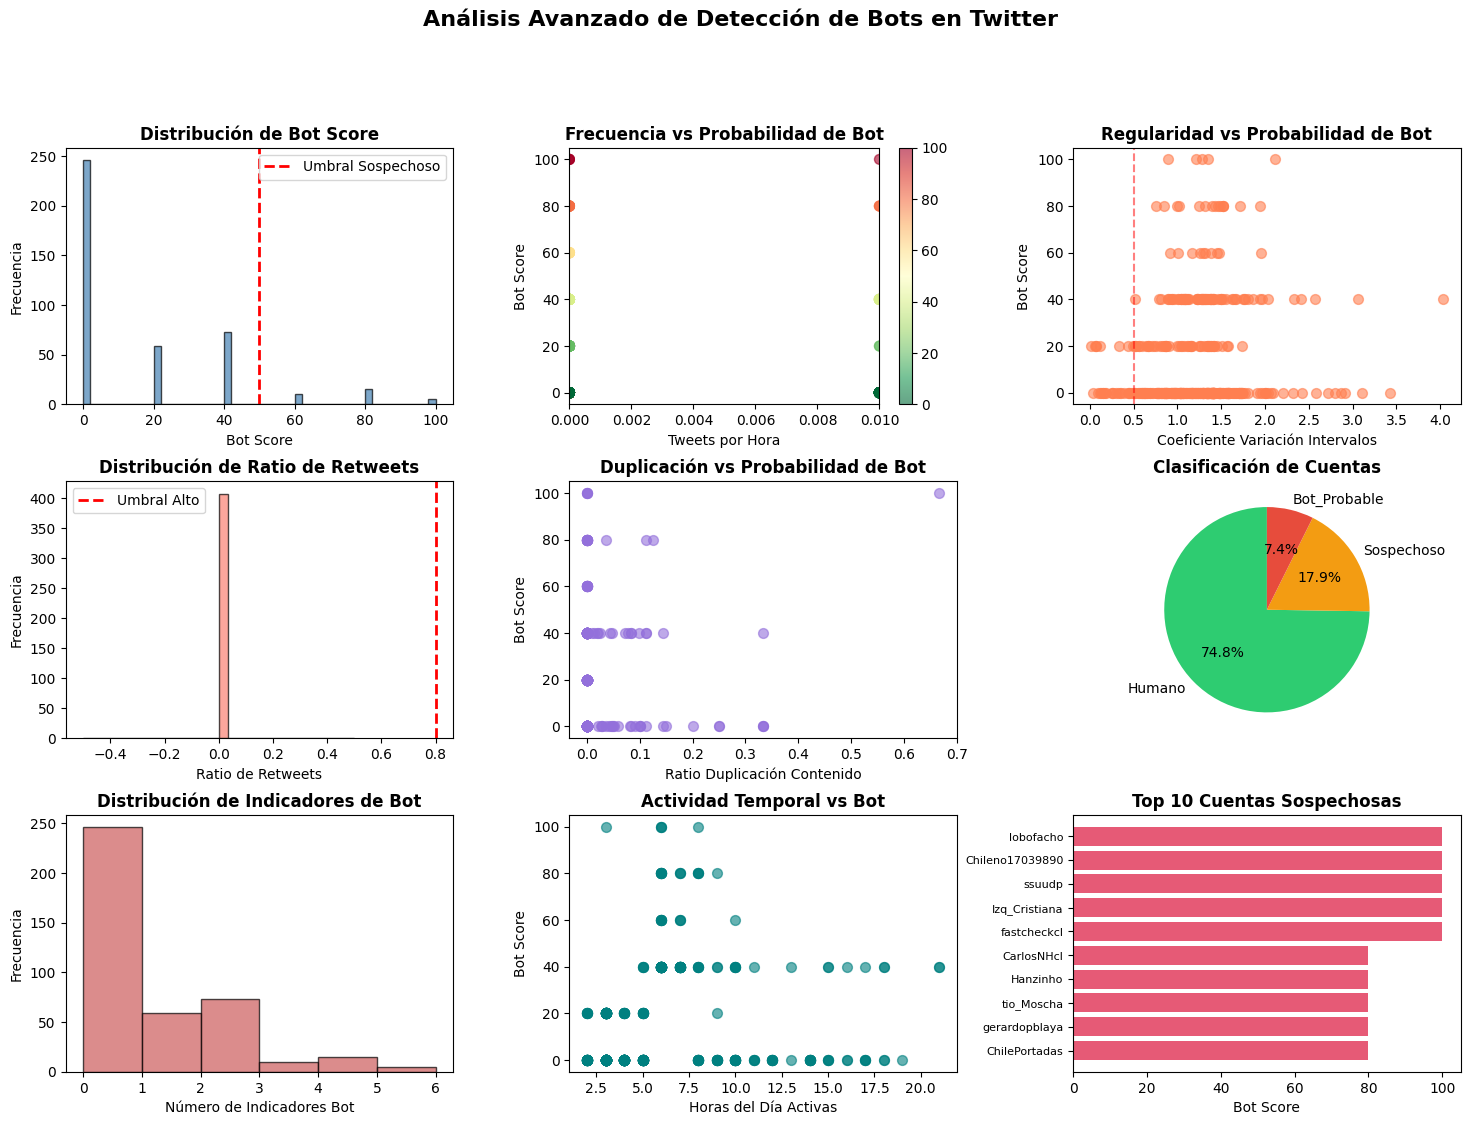

In [81]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy import stats

# Leer datos
data1 = pd.read_csv('../data/Tweets_Elecciones2025_Chile.csv')

# Convertir fecha a datetime
data1['UTC_Time'] = pd.to_datetime(data1['UTC_Time'])
data1['hora'] = data1['UTC_Time'].dt.hour
data1['minuto'] = data1['UTC_Time'].dt.minute
data1['dia_semana'] = data1['UTC_Time'].dt.dayofweek

print("Analizando patrones de comportamiento...")
print(f"Total de tweets: {len(data1)}")
print(f"Total de usuarios: {data1['Author_Handle'].nunique()}")

# Función mejorada con más métricas sensibles
def analisis_avanzado_comportamiento(df):
    """
    Análisis más sensible basado en investigación de detección de bots
    """
    resultados = []
    
    for author in df['Author_Handle'].unique():
        user_data = df[df['Author_Handle'] == author].copy()
        user_data = user_data.sort_values('UTC_Time')
        
        n_tweets = len(user_data)
        
        # Filtrar usuarios con actividad mínima
        if n_tweets < 3:
            continue
        
        # === ANÁLISIS TEMPORAL ===
        tiempo_total = (user_data['UTC_Time'].max() - user_data['UTC_Time'].min()).total_seconds() / 3600
        tweets_per_hour = n_tweets / tiempo_total if tiempo_total > 0 else 0
        
        # Intervalos entre tweets
        intervalos = user_data['UTC_Time'].diff().dt.total_seconds().dropna()
        
        if len(intervalos) > 0:
            mean_intervalo = intervalos.mean()
            std_intervalo = intervalos.std()
            cv_intervalo = std_intervalo / mean_intervalo if mean_intervalo > 0 else 0
            
            # Detectar patrones exactos (segundos exactos)
            intervalos_segundos = intervalos.round(0)
            intervalos_unicos = len(intervalos_segundos.unique())
            ratio_intervalos_repetidos = 1 - (intervalos_unicos / len(intervalos_segundos))
            
            # Intervalos sospechosamente regulares (ej: cada 60s, 120s, 300s)
            intervalos_comunes = intervalos_segundos.mode()[0] if len(intervalos_segundos) > 0 else 0
            frecuencia_intervalo_comun = (intervalos_segundos == intervalos_comunes).sum() / len(intervalos_segundos)
        else:
            cv_intervalo = 0
            ratio_intervalos_repetidos = 0
            frecuencia_intervalo_comun = 0
            intervalos_comunes = 0
        
        # === ANÁLISIS DE CONTENIDO ===
        # Tweets idénticos
        tweets_unicos = user_data['Tweet_Content'].nunique()
        ratio_duplicacion = 1 - (tweets_unicos / n_tweets)
        
        # Longitud de tweets
        longitudes = user_data['Tweet_Content'].str.len()
        mean_longitud = longitudes.mean()
        std_longitud = longitudes.std()
        cv_longitud = std_longitud / mean_longitud if mean_longitud > 0 else 0
        
        # Detectar tweets muy similares (primeras 50 caracteres)
        prefijos = user_data['Tweet_Content'].str[:50]
        prefijos_unicos = prefijos.nunique()
        ratio_prefijos_repetidos = 1 - (prefijos_unicos / n_tweets)
        
        # === ANÁLISIS DE TIPO DE ACTIVIDAD ===
        type_counts = user_data['Type'].value_counts(normalize=True)
        ratio_retweets = type_counts.get('retweet', 0) if isinstance(type_counts.index[0], str) else 0
        ratio_replies = type_counts.get('reply', 0) if isinstance(type_counts.index[0], str) else 0
        ratio_quotes = type_counts.get('quote', 0) if isinstance(type_counts.index[0], str) else 0
        
        # Bot de amplificación: solo retweets
        solo_retweets = ratio_retweets > 0.95
        
        # === ANÁLISIS DE ENGAGEMENT ===
        engagement_total = (
            user_data['Reply_Count'].fillna(0) + 
            user_data['Repost_Count'].fillna(0) + 
            user_data['Like_Count'].fillna(0)
        )
        engagement_promedio = engagement_total.mean()
        engagement_mediana = engagement_total.median()
        
        # Ratio engagement/followers (aproximado por views)
        views_promedio = user_data['View_Count'].fillna(0).mean()
        ratio_engagement_views = engagement_promedio / views_promedio if views_promedio > 0 else 0
        
        # === ANÁLISIS DE PATRONES HORARIOS ===
        horas_activas = user_data['hora'].nunique()
        
        # Distribución horaria (entropía)
        distribucion_horas = user_data['hora'].value_counts(normalize=True)
        entropia_horas = stats.entropy(distribucion_horas) if len(distribucion_horas) > 1 else 0
        
        # Actividad en horas atípicas (madrugada: 2-6 AM)
        tweets_madrugada = user_data[user_data['hora'].between(2, 6)].shape[0]
        ratio_madrugada = tweets_madrugada / n_tweets
        
        # === ANÁLISIS DE FUENTE/ORIGEN ===
        # Detectar si todos los tweets son desde misma fuente
        sources = user_data.get('Source', pd.Series([None]*len(user_data)))
        sources_unicos = sources.nunique()
        
        # === INDICADORES DE BOT ===
        indicadores_bot = 0
        
        # 1. Alta frecuencia (>3 tweets/hora)
        if tweets_per_hour > 3:
            indicadores_bot += 2
        if tweets_per_hour > 10:
            indicadores_bot += 3
            
        # 2. Intervalos muy regulares (CV < 0.5)
        if cv_intervalo < 0.5 and n_tweets > 5:
            indicadores_bot += 3
            
        # 3. Muchos intervalos repetidos
        if ratio_intervalos_repetidos > 0.5:
            indicadores_bot += 2
            
        # 4. Intervalo común muy frecuente (>60% tweets con mismo intervalo)
        if frecuencia_intervalo_comun > 0.6:
            indicadores_bot += 3
            
        # 5. Alto ratio de contenido duplicado
        if ratio_duplicacion > 0.5:
            indicadores_bot += 3
            
        # 6. Prefijos muy repetidos (copy-paste)
        if ratio_prefijos_repetidos > 0.6:
            indicadores_bot += 2
            
        # 7. Solo retweets
        if solo_retweets:
            indicadores_bot += 4
            
        # 8. Muy alto ratio de retweets (>80%)
        if ratio_retweets > 0.8:
            indicadores_bot += 2
            
        # 9. Actividad 24/7
        if horas_activas > 20:
            indicadores_bot += 2
            
        # 10. Baja entropía horaria (siempre a las mismas horas)
        if entropia_horas < 2.0 and horas_activas > 5:
            indicadores_bot += 2
            
        # 11. Mucha actividad en madrugada
        if ratio_madrugada > 0.3:
            indicadores_bot += 1
            
        # 12. Bajo engagement
        if engagement_promedio < 1 and n_tweets > 10:
            indicadores_bot += 1
            
        # 13. Longitud muy uniforme
        if cv_longitud < 0.2 and n_tweets > 5:
            indicadores_bot += 2
        
        resultados.append({
            'Author_Handle': author,
            'Author_Name': user_data['Author_Name'].iloc[0],
            'Total_Tweets': n_tweets,
            'Tweets_Per_Hour': round(tweets_per_hour, 2),
            'CV_Intervalos': round(cv_intervalo, 3),
            'Ratio_Intervalos_Repetidos': round(ratio_intervalos_repetidos, 3),
            'Frecuencia_Intervalo_Comun': round(frecuencia_intervalo_comun, 3),
            'Intervalo_Comun_Segundos': intervalos_comunes,
            'Ratio_Duplicacion_Contenido': round(ratio_duplicacion, 3),
            'Ratio_Prefijos_Repetidos': round(ratio_prefijos_repetidos, 3),
            'Ratio_Retweets': round(ratio_retweets, 3),
            'Solo_Retweets': solo_retweets,
            'Horas_Activas': horas_activas,
            'Entropia_Horaria': round(entropia_horas, 3),
            'Ratio_Actividad_Madrugada': round(ratio_madrugada, 3),
            'Engagement_Promedio': round(engagement_promedio, 2),
            'CV_Longitud': round(cv_longitud, 3),
            'Indicadores_Bot': indicadores_bot,
            'Verified': user_data['Verified_Status'].iloc[0] if 'Verified_Status' in user_data.columns else False
        })
    
    return pd.DataFrame(resultados)

# Ejecutar análisis
metricas = analisis_avanzado_comportamiento(data1)

# Calcular Bot Score normalizado (0-100)
max_indicadores = metricas['Indicadores_Bot'].max()
if max_indicadores > 0:
    metricas['Bot_Score'] = (metricas['Indicadores_Bot'] / max_indicadores * 100).round(1)
else:
    metricas['Bot_Score'] = 0

# Clasificación más estricta
metricas['Clasificacion'] = pd.cut(
    metricas['Bot_Score'],
    bins=[-1, 20, 50, 100],
    labels=['Humano', 'Sospechoso', 'Bot_Probable']
)

# Ordenar por score
metricas = metricas.sort_values('Bot_Score', ascending=False)

# Guardar resultados
metricas.to_csv('../data/analisis_bots_mejorado.csv', index=False)

# REPORTES
print("\n" + "="*80)
print("ANÁLISIS AVANZADO DE DETECCIÓN DE BOTS")
print("="*80)

print(f"\nUsuarios analizados: {len(metricas)}")
print(f"\nDistribución de clasificación:")
print(metricas['Clasificacion'].value_counts())
print(f"\nEstadísticas del Bot Score:")
print(metricas['Bot_Score'].describe())

print("\n" + "="*80)
print("TOP 20 CUENTAS CON MAYOR PROBABILIDAD DE SER BOTS")
print("="*80)
top_bots = metricas.head(20)[[
    'Author_Handle', 'Total_Tweets', 'Bot_Score', 'Indicadores_Bot',
    'Tweets_Per_Hour', 'Ratio_Retweets', 'Solo_Retweets',
    'Ratio_Duplicacion_Contenido', 'CV_Intervalos', 'Clasificacion'
]]
print(top_bots.to_string(index=False))

# Análisis de patrones específicos
print("\n" + "="*80)
print("PATRONES SOSPECHOSOS DETECTADOS")
print("="*80)

# Cuentas con intervalos muy regulares
regulares = metricas[(metricas['CV_Intervalos'] < 0.5) & (metricas['Total_Tweets'] > 10)]
print(f"\n1. Cuentas con intervalos muy regulares: {len(regulares)}")
if len(regulares) > 0:
    print(regulares.head(5)[['Author_Handle', 'CV_Intervalos', 'Frecuencia_Intervalo_Comun', 'Bot_Score']])

# Cuentas solo retweets
solo_rt = metricas[metricas['Solo_Retweets'] == True]
print(f"\n2. Cuentas que SOLO hacen retweets: {len(solo_rt)}")
if len(solo_rt) > 0:
    print(solo_rt.head(5)[['Author_Handle', 'Total_Tweets', 'Ratio_Retweets', 'Bot_Score']])

# Contenido muy duplicado
duplicados = metricas[metricas['Ratio_Duplicacion_Contenido'] > 0.7]
print(f"\n3. Cuentas con contenido muy duplicado: {len(duplicados)}")
if len(duplicados) > 0:
    print(duplicados.head(5)[['Author_Handle', 'Ratio_Duplicacion_Contenido', 'Ratio_Prefijos_Repetidos', 'Bot_Score']])

# Alta frecuencia
alta_freq = metricas[metricas['Tweets_Per_Hour'] > 5]
print(f"\n4. Cuentas con alta frecuencia (>5 tweets/hora): {len(alta_freq)}")
if len(alta_freq) > 0:
    print(alta_freq.head(5)[['Author_Handle', 'Tweets_Per_Hour', 'Total_Tweets', 'Bot_Score']])

# Visualizaciones mejoradas
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Distribución Bot Score
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(metricas['Bot_Score'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(50, color='red', linestyle='--', linewidth=2, label='Umbral Sospechoso')
ax1.set_xlabel('Bot Score', fontsize=10)
ax1.set_ylabel('Frecuencia', fontsize=10)
ax1.set_title('Distribución de Bot Score', fontsize=12, fontweight='bold')
ax1.legend()

# 2. Tweets/hora vs Bot Score
ax2 = fig.add_subplot(gs[0, 1])
scatter = ax2.scatter(metricas['Tweets_Per_Hour'], metricas['Bot_Score'], 
                     c=metricas['Bot_Score'], cmap='RdYlGn_r', alpha=0.6, s=50)
ax2.set_xlabel('Tweets por Hora', fontsize=10)
ax2.set_ylabel('Bot Score', fontsize=10)
ax2.set_title('Frecuencia vs Probabilidad de Bot', fontsize=12, fontweight='bold')
ax2.set_xlim(0, min(metricas['Tweets_Per_Hour'].quantile(0.95), metricas['Tweets_Per_Hour'].max()))
plt.colorbar(scatter, ax=ax2)

# 3. CV Intervalos vs Bot Score
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(metricas['CV_Intervalos'], metricas['Bot_Score'], alpha=0.6, s=50, color='coral')
ax3.set_xlabel('Coeficiente Variación Intervalos', fontsize=10)
ax3.set_ylabel('Bot Score', fontsize=10)
ax3.set_title('Regularidad vs Probabilidad de Bot', fontsize=12, fontweight='bold')
ax3.axvline(0.5, color='red', linestyle='--', alpha=0.5)

# 4. Ratio Retweets
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(metricas['Ratio_Retweets'], bins=30, edgecolor='black', alpha=0.7, color='salmon')
ax4.axvline(0.8, color='red', linestyle='--', linewidth=2, label='Umbral Alto')
ax4.set_xlabel('Ratio de Retweets', fontsize=10)
ax4.set_ylabel('Frecuencia', fontsize=10)
ax4.set_title('Distribución de Ratio de Retweets', fontsize=12, fontweight='bold')
ax4.legend()

# 5. Duplicación de contenido
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(metricas['Ratio_Duplicacion_Contenido'], metricas['Bot_Score'], 
           alpha=0.6, s=50, color='mediumpurple')
ax5.set_xlabel('Ratio Duplicación Contenido', fontsize=10)
ax5.set_ylabel('Bot Score', fontsize=10)
ax5.set_title('Duplicación vs Probabilidad de Bot', fontsize=12, fontweight='bold')

# 6. Clasificación
ax6 = fig.add_subplot(gs[1, 2])
clasificacion_counts = metricas['Clasificacion'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e74c3c']
ax6.pie(clasificacion_counts, labels=clasificacion_counts.index, autopct='%1.1f%%', 
       startangle=90, colors=colors[:len(clasificacion_counts)])
ax6.set_title('Clasificación de Cuentas', fontsize=12, fontweight='bold')

# 7. Indicadores de bot
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist(metricas['Indicadores_Bot'], bins=range(0, int(metricas['Indicadores_Bot'].max())+2), 
        edgecolor='black', alpha=0.7, color='indianred')
ax7.set_xlabel('Número de Indicadores Bot', fontsize=10)
ax7.set_ylabel('Frecuencia', fontsize=10)
ax7.set_title('Distribución de Indicadores de Bot', fontsize=12, fontweight='bold')

# 8. Actividad temporal
ax8 = fig.add_subplot(gs[2, 1])
ax8.scatter(metricas['Horas_Activas'], metricas['Bot_Score'], alpha=0.6, s=50, color='teal')
ax8.set_xlabel('Horas del Día Activas', fontsize=10)
ax8.set_ylabel('Bot Score', fontsize=10)
ax8.set_title('Actividad Temporal vs Bot', fontsize=12, fontweight='bold')

# 9. Top 10 bots
ax9 = fig.add_subplot(gs[2, 2])
top10 = metricas.head(10)
ax9.barh(range(len(top10)), top10['Bot_Score'], color='crimson', alpha=0.7)
ax9.set_yticks(range(len(top10)))
ax9.set_yticklabels([h[:15] + '...' if len(h) > 15 else h for h in top10['Author_Handle']], fontsize=8)
ax9.set_xlabel('Bot Score', fontsize=10)
ax9.set_title('Top 10 Cuentas Sospechosas', fontsize=12, fontweight='bold')
ax9.invert_yaxis()

plt.suptitle('Análisis Avanzado de Detección de Bots en Twitter', 
            fontsize=16, fontweight='bold', y=0.995)

plt.savefig('../data/analisis_bots_mejorado.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Visualización guardada: ../data/analisis_bots_mejorado.png")
print(f"✓ Resultados guardados: ../data/analisis_bots_mejorado.csv")

plt.show()

## Parte 2

### Construcción de grafo

### Métodos de detección de comunidades

### Extracción de asociaciones temáticas clave

### Visualización con nubes de palabras y grafos

### Comparación de trafico (Humanos VS Cuentas sospechosas)

## Las celdas deben estar comentadas!
## Deben haber graficos!!

# Preguntas orientadoras:



## Parte 1
- ¿Qué diferencias se observan en la velocidad y alcance de la difusión de rumores frente a publicaciones legítimas?
- ¿Qué métricas de red resultan más útiles para identificar a los principales difusores?
- ¿Qué patrones sugieren la presencia de bots en la propagación?
- ¿Existen variaciones geográficas en la propagación del rumor?

## Parte 2
- ¿Qué candidatos aparecen más vinculados a comunidades de desinformación?
- ¿Qué términos o narrativas destacan en las comunidades y qué sesgos reflejan?
- ¿Qué patrones de conexión entre comunidades ayudan a explicar la propagación de narrativas falsas?
- ¿Qué diferencias se observan entre comunidades dominadas por humanos y aquellas potenciadas por bots?

# Discusión

***La discusión debe estar conectada con las preguntas orientadoras***